#Regression Model Version

# Reference Material

#https://www.scribd.com/document/826659027/Novel-Optimization-Approach-for-Stock-Price-Forecasting-Using

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install yfinance --upgrade --no-cache-dir

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

#Download Stock Data

In [4]:

ticker = "AAPL"
data = yf.download(ticker, start="2024-01-01", end="2025-10-27") #2020-01-01 | 2022-07-02 | 2024-01-01 | 2024-12-31 | 2025-10-25
data = data[['Close']].dropna()


/tmp/ipython-input-210797312.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2024-01-01", end="2025-10-27") #2020-01-01 | 2022-07-02 | 2024-01-01 | 2024-12-31 | 2025-10-25
[*********************100%***********************]  1 of 1 completed


# Normalize and Prepare Data

In [5]:
# time_step: The number of past days the model looks at to predict the next day’s price.
# If time_step = 100, the model sees 100 days of prices → predicts day 101. (hopefully...)
# X shape → (samples, 100, 1)
# y shape → (samples, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step=100):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)


# Train-Test Split

In [63]:
# Splitting the dataset into training (65%) and testing (35%) sets.
# Data is chronologically ordered before the split
'''
train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples (last {train_size} days): {len(X_test)}")
'''

test_size = 10

X_train = X[:-test_size]
y_train = y[:-test_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples (last {test_size} days): {len(X_test)}")

Training samples: 346
Testing samples (last 10 days): 10


# Build the MLS LSTM Model

In [64]:
# LSTM(50): 50 hidden units per LSTM layer.
# return_sequences=True: Keeps the sequence output for stacking layers.
# input_shape=(100,1): 100 time steps, 1 feature (price).
# Dense(1): Output layer predicts one continuous value???
# loss='mean_squared_error': Penalizes squared error between predicted and true prices.
# optimizer='adam': Adaptive optimizer, commonly used for time series.

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the Model

In [65]:
# validation_split=0.1: 10% of training data used for validation.
# epochs=100: Maximum number of passes through the data.
# batch_size=64: Updates weights every 64 samples.
# verbose=1: Shows live progress.

model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.2839 - val_loss: 0.1395
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0402 - val_loss: 0.0046
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0252 - val_loss: 0.0883
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0300 - val_loss: 0.0549
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0136 - val_loss: 0.0116
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0145 - val_loss: 0.0176
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0118 - val_loss: 0.0410
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0125 - val_loss: 0.0330
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0116 - val_loss: 0.0185
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0118 - val_loss: 0.0242
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0101 - val_loss: 0.0259
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0106 - val_l

# Make Predictions and Inverse Transform

In [66]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

#NOTE: You may get the warning: WARNING:tensorflow:5 out of the last 13 calls to...
#Ignore it, it's fine. I think it's just warning us about needless overhead that tensorflow is doing

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


# Evaluate Performance

In [67]:
# R²: How much variance is explained (closer to 1 = better).
# MAPE: Percent error between actual and predicted prices.

print("R² (Train):", r2_score(y_train_inv, train_predict))
print("R² (Test):", r2_score(y_test_inv, test_predict))
print("MAPE (Test):", mean_absolute_percentage_error(y_test_inv, test_predict))


R² (Train): 0.8630986181089595
R² (Test): -0.7715071370778928
MAPE (Test): 0.025927157652064166


# Placeholder Buy/Sell/Hold Logic

In [68]:
# Converts price predictions into trading actions (Buy/Sell/Hold).
# Will predict today's price and tomorrows price, and decide from there

# threshold: relationship between threshold/change determines buy/sell/hold
# cooldown: how many days you wait before deciding to buy/sell/hold (was buying/selling for 20 straight days before)

# Checks how much higher or lower the predicted price of today is, relative to the predicted tomorrow price.
# If change rises above 1% threshold, it triggers a “Buy”.
# If it falls below 1% threshold, it triggers a “Sell”.
# Otherwise → “Hold”.

def generate_signals(predicted_prices, threshold=0.01, cooldown=0):
    signals = []
    last_action_day = -cooldown

    for i in range(len(predicted_prices) - 1):
        future_change = (predicted_prices[i + 1] - predicted_prices[i]) / predicted_prices[i]

        if i - last_action_day < cooldown:
            signals.append("Hold")
            continue

        if future_change > threshold:
            signals.append("Sell")
            last_action_day = i

        elif future_change < -threshold:
            signals.append("Buy")
            last_action_day = i

        else:
            signals.append("Hold")

    signals.append("Hold")
    return signals


# Apply Signals to Test Set

In [71]:
signals = generate_signals(test_predict.flatten(), threshold=0.005, cooldown=3) #Drop threshold lower for more frequent buy/sell/hold decisions

for i in range(9):  # Predicting 10 days, but only 9 future predictions can be made
    print(f"Predicted Today: {test_predict[i][0]:.2f}, "
          f"Predicted Tomorrow: {test_predict[i+1][0]:.2f}, "
          f"Signal: {signals[i]}")


Predicted Today: 256.66, Predicted Tomorrow: 253.40, Signal: Buy
Predicted Today: 253.40, Predicted Tomorrow: 250.16, Signal: Hold
Predicted Today: 250.16, Predicted Tomorrow: 247.69, Signal: Hold
Predicted Today: 247.69, Predicted Tomorrow: 245.81, Signal: Buy
Predicted Today: 245.81, Predicted Tomorrow: 245.37, Signal: Hold
Predicted Today: 245.37, Predicted Tomorrow: 247.79, Signal: Hold
Predicted Today: 247.79, Predicted Tomorrow: 252.08, Signal: Sell
Predicted Today: 252.08, Predicted Tomorrow: 256.26, Signal: Hold
Predicted Today: 256.26, Predicted Tomorrow: 259.79, Signal: Hold


# Visualize the Signals

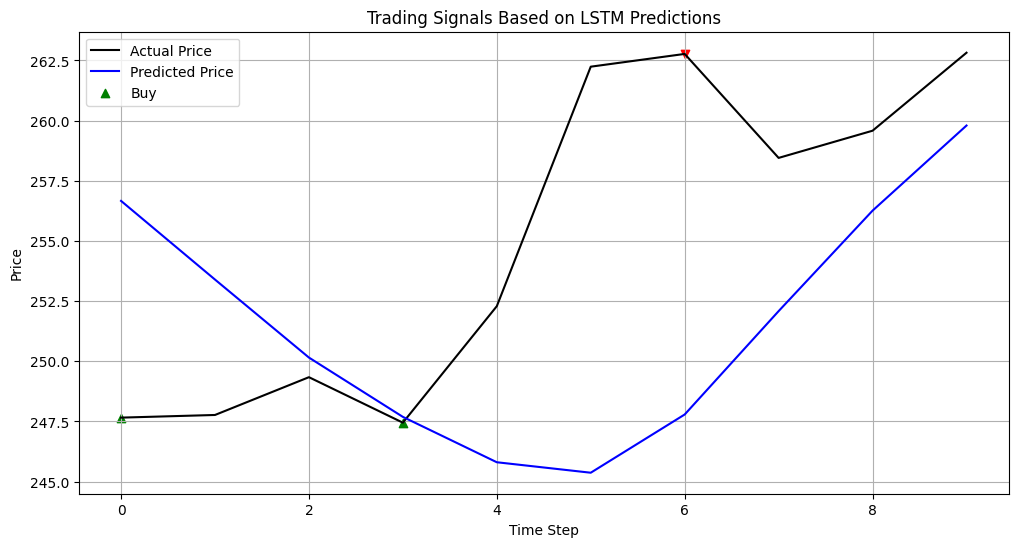

In [72]:


plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price', color='black')
plt.plot(test_predict, label='Predicted Price', color='blue')

# Mark buy/sell signals
for i, signal in enumerate(signals):
    if signal == "Buy":
        plt.scatter(i, y_test_inv[i], color='green', marker='^', label='Buy' if i == 0 else "")
    elif signal == "Sell":
        plt.scatter(i, y_test_inv[i], color='red', marker='v', label='Sell' if i == 0 else "")

plt.title("Trading Signals Based on LSTM Predictions")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


#Simulate Portfolio

In [73]:
# prices: actual prices
# signals: buy/sell/hold signals made from LSTM predictions

def simulate_portfolio(actual_prices, signals, initial_cash=10000):
    """
    Simulates a portfolio based on predicted prices and model signals.

    Parameters:
        predicted_prices (array-like): The model's predicted prices.
        signals (list): Generated trading signals ("Buy", "Sell", "Hold").
        initial_cash (float): Starting amount of money.
    """
    cash = initial_cash
    shares = 0
    portfolio_values = []

    for i in range(len(actual_prices)):
        price = actual_prices[i]
        signal = signals[i]

        # BUY: use all cash to buy shares
        if signal == "Buy" and cash > 0:
            shares = cash / price
            cash = 0

        # SELL: sell all shares and convert to cash
        elif signal == "Sell" and shares > 0:
            cash = shares * price
            shares = 0

        # Calculate total portfolio value
        portfolio_value = cash + shares * price
        portfolio_values.append(portfolio_value)

    return portfolio_values

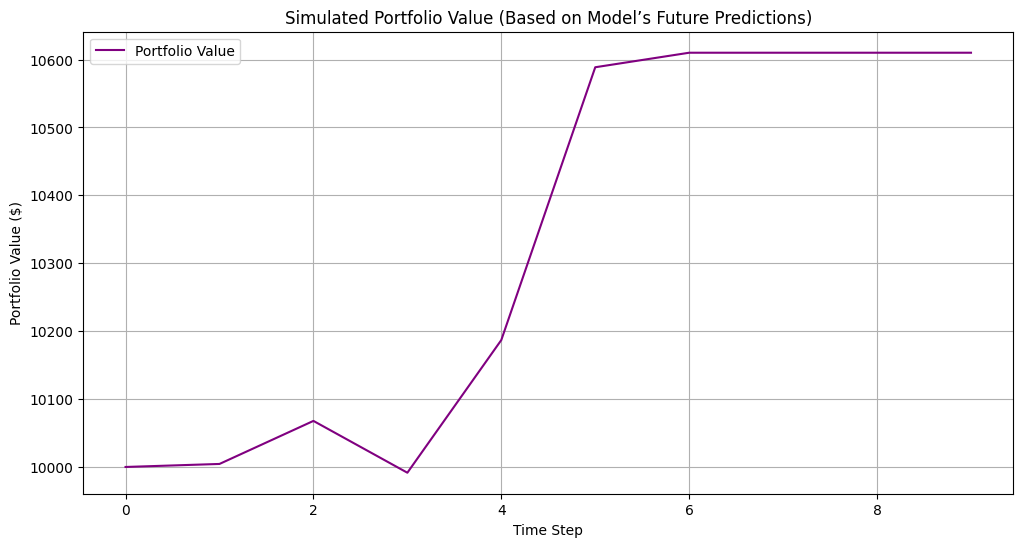

In [74]:
portfolio_values = simulate_portfolio(
    actual_prices=y_test_inv.flatten(),
    signals=signals,
    initial_cash=10000
)

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value', color='purple')
plt.title("Simulated Portfolio Value (Based on Model’s Future Predictions)")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.show()


In [75]:
final_value = portfolio_values[-1]
roi = (final_value - 10000) / 10000 * 100

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Return on Investment (ROI): {roi:.2f}%")

Final Portfolio Value: $10610.11
Return on Investment (ROI): 6.10%
